In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import float32, zeros, ones, eye, as_tensor, tensor

from sbi.inference import MCMCPosterior, VIPosterior, ImportanceSamplingPosterior
from sbi.analysis import pairplot
from sbi.utils import mcmc_transform

from gbi.GBI import GBInference
from gbi.hh.train_gbi import MaeDistZ
import gbi.hh.utils as utils
from gbi.hh.HodgkinHuxley import HodgkinHuxley
from gbi.hh.HodgkinHuxleyStatsMoments import HodgkinHuxleyStatsMoments

/home/anonymizeduser/anaconda3/envs/gbi/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
plt.style.use('../../../.matplotlibrc')

In [19]:
col_xo = "k"
col_npe = "C2"
col_gbi = "C1"
col_gbi1 = "#74a9cf"
col_gbi2 = "#3690c0"
col_gbi3 = "#045a8d"

### Load data

In [8]:
obs_stats_ls, all_obs = utils.load_all_allen()

In [9]:
path = "/home/anonymizeduser/Documents/neuralgbi/results/hh_allen"

In [36]:
with open(f"{path}/gbi_pred_m/0/03_posterior_predictive_traces_gbi.pkl", "rb") as handle:
    gbi_posterior_traces = pickle.load(handle)
with open(f"{path}/npe_pred_m/0_allen_100000/04_npe_traces.pkl", "rb") as handle:
    npe_posterior_traces = pickle.load(handle)
with open(f"{path}/npe_pred_m/3_allen_1000000/04_npe_traces.pkl", "rb") as handle:
    npe_posterior_1M_traces = pickle.load(handle)

### Set up simulator

In [11]:
true_params, labels_params = utils.obs_params(reduced_model=False)

list_cells_AllenDB = [518290966, 57, 0.0234 / 126]

ephys_cell = list_cells_AllenDB[0]
sweep_number = list_cells_AllenDB[1]
A_soma = list_cells_AllenDB[2]
junction_potential = -14

obs = utils.allen_obs_data(
    ephys_cell=ephys_cell, sweep_number=sweep_number, A_soma=A_soma
)
obs["data"] = obs["data"] + junction_potential
I = obs["I"]
dt = obs["dt"]
t_on = obs["t_on"]
t_off = obs["t_off"]

sim = HodgkinHuxley(
    I, dt, V0=obs["data"][0], reduced_model=False, cython=True, prior_log=False
)

In [12]:
time_vec_obs = np.linspace(np.min(sim.t), np.max(sim.t), len(all_obs[0]["data"]))

In [43]:
def plot_samples(predictives, sample_cols):
    nsamples = 10
    nxo = 10
    
    fig, ax = plt.subplots(nsamples, nxo, figsize=(12, 8))
        
    for i in range(nxo):
        xo  = all_obs[i]
        _ = ax[0, i].plot(time_vec_obs, xo["data"], c="k")
        
        for j in range(1, nsamples):
            xo = predictives[i][j]
            _ = ax[j, i].plot(time_vec_obs, xo["data"], c=sample_cols)

    
    for i in range(nxo):
        for j in range(nsamples):
            _ = ax[j, i].set_xlabel("")
            _ = ax[j, i].set_ylabel("")
            _ = ax[j, i].set_ylim([-100, 60])
            _ = ax[j, i].spines["left"].set_visible(False)
            _ = ax[j, i].spines["bottom"].set_visible(False)
            _ = ax[j, i].set_xticks([])
            _ = ax[j, i].set_yticks([])
    return fig, ax

### GBI

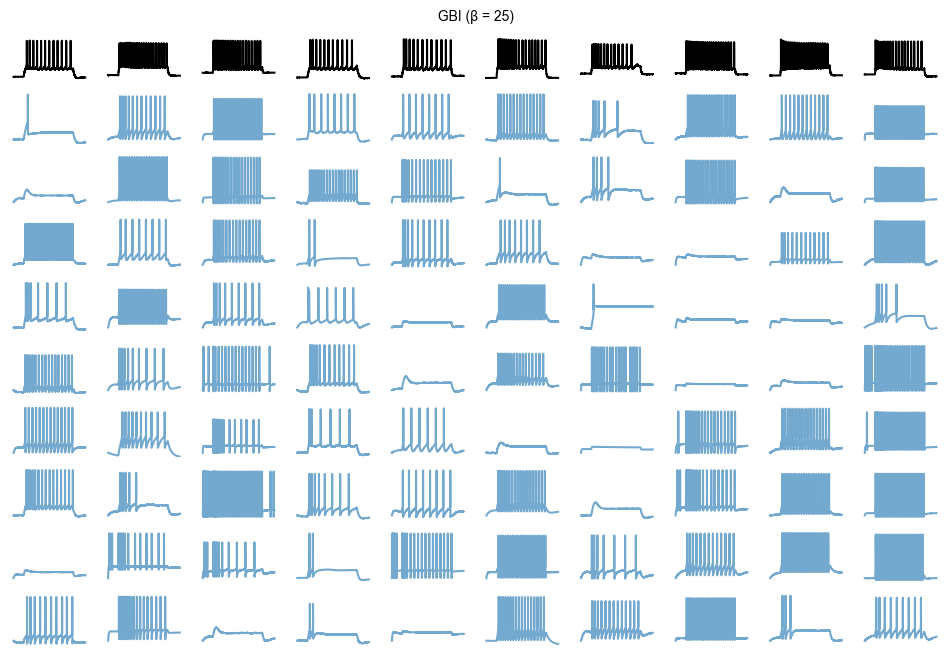

In [44]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plot_samples(gbi_posterior_traces["beta_25"], sample_cols=col_gbi1)
    ax[0, 4].set_title("                         GBI (β = 25)", fontsize=10.0)
    plt.savefig("../fig/fig6_appendix1.svg")
    plt.show()

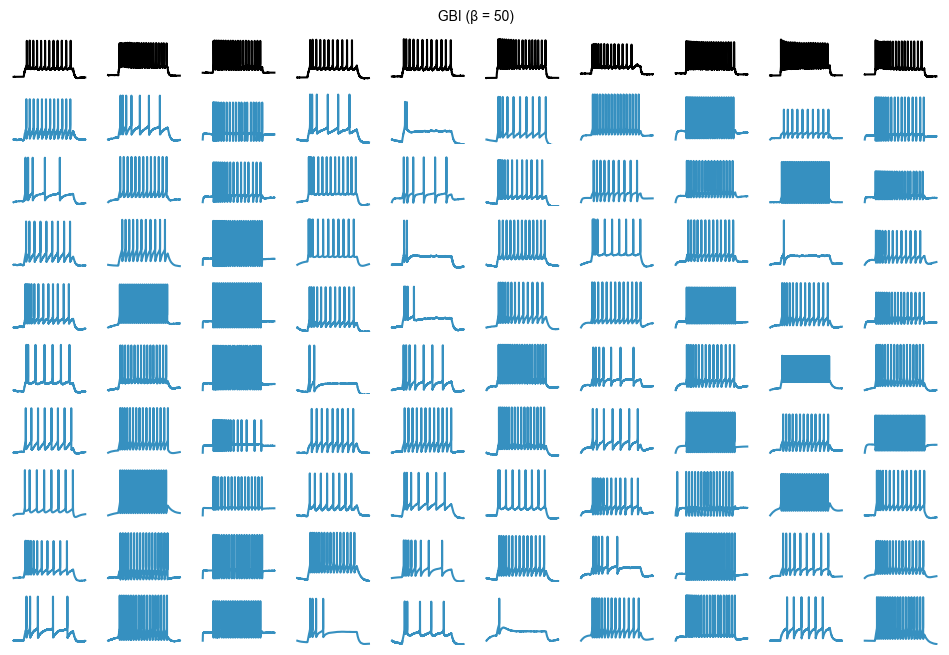

In [45]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plot_samples(gbi_posterior_traces["beta_50"], sample_cols=col_gbi2)
    ax[0, 4].set_title("                         GBI (β = 50)", fontsize=10.0)
    plt.savefig("../fig/fig6_appendix2.svg")
    plt.show()

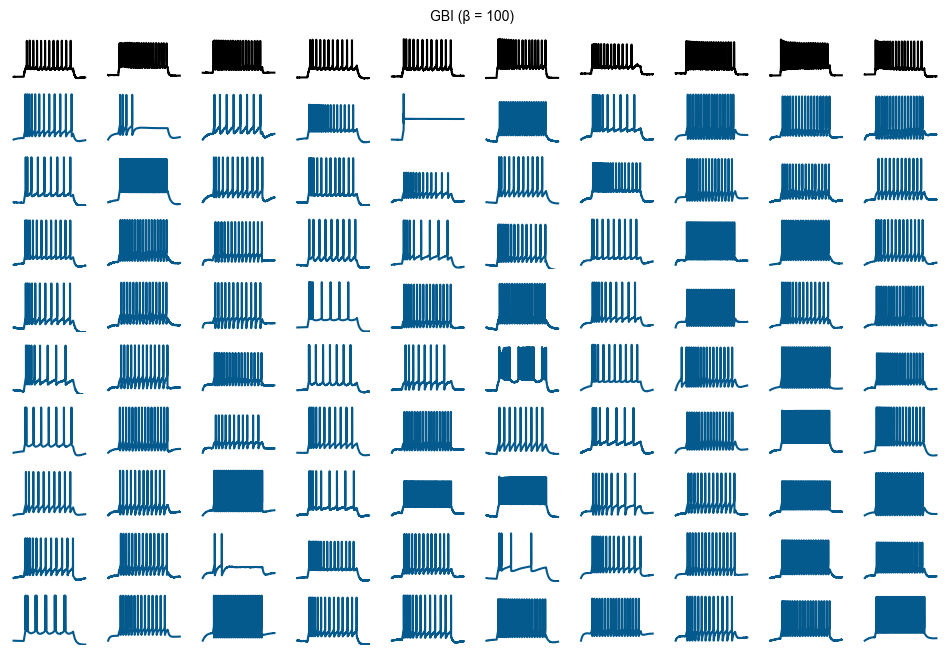

In [46]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plot_samples(gbi_posterior_traces["beta_100"], sample_cols=col_gbi3)
    ax[0, 4].set_title("                       GBI (β = 100)", fontsize=10.0)
    plt.savefig("../fig/fig6_appendix3.svg")
    plt.show()

### NPE

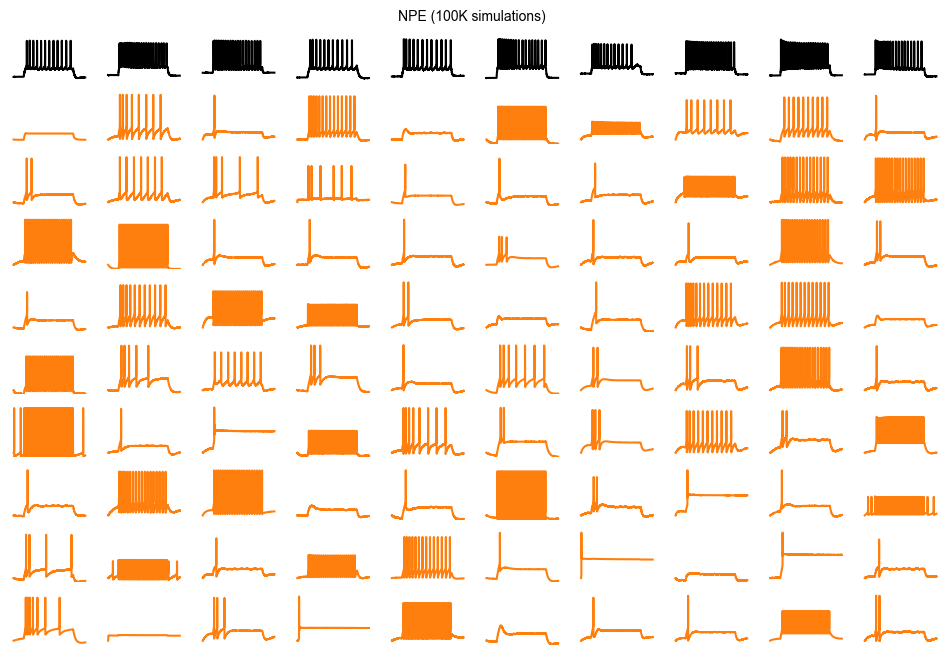

In [49]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plot_samples(npe_posterior_traces, sample_cols=col_npe)
    ax[0, 4].set_title("                       NPE (100K simulations)", fontsize=10.0)
    plt.savefig("../fig/fig6_appendix4.svg")
    plt.show()

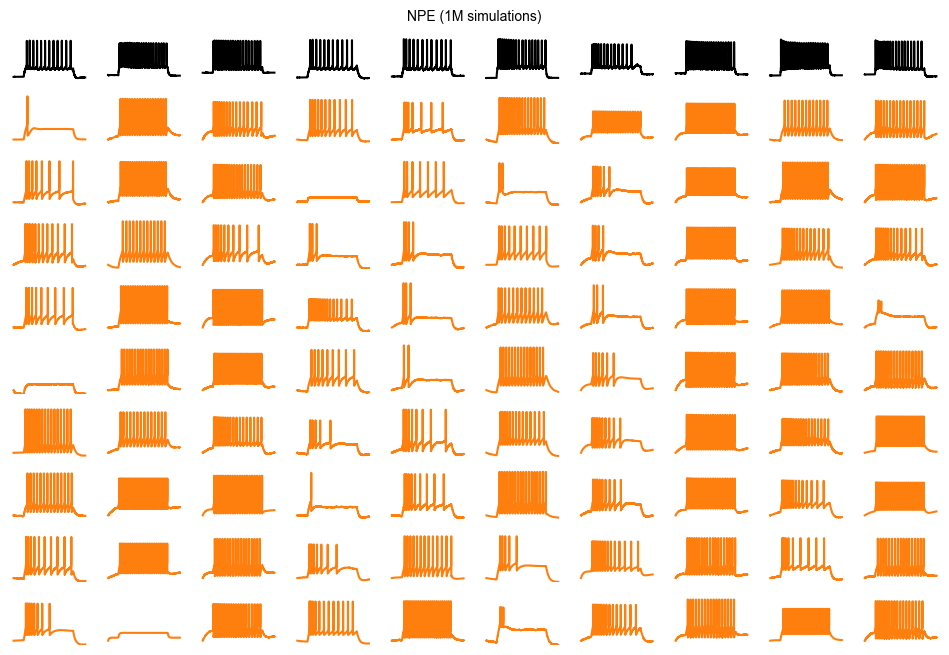

In [51]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plot_samples(npe_posterior_1M_traces, sample_cols=col_npe)
    ax[0, 4].set_title("                        NPE (1M simulations)", fontsize=10.0)
    plt.savefig("../fig/fig6_appendix5.svg")
    plt.show()